# Pump it Up: Data Mining the Water Table
HOSTED BY DRIVENDATA

## 0. Introduction
The datasets are hosted by DrivenData: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/

The data consist of information (40 features) on water wells in Tanzania.
The goal is to predict whether a well is "functional", "functional but in need of repairs", or "non functional".

The datasets are:
- Training set values (59,400 observations, 40 variables: id, date, location, installer, etc.)
- Training set labels (59,400 observations, 2 variables: id, status_group)
- Test set values (14,850 observations, 40 variables)

## 1. Exploration and visualization of the data

In [16]:
# Read the test dataset
test <- read.csv('TestSetValues.csv')
head(test)
str(test)

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
50785,0,2013-02-04,Dmdd,1996,DMDD,35.29080,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0,2013-02-04,Government Of Tanzania,1569,DWE,36.65671,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0,2013-02-01,,1567,,34.76786,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0,2013-01-22,Finn Water,267,FINN WATER,38.05805,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500,2013-03-27,Bruder,1260,BRUDER,35.00612,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
52449,0,2013-03-04,Government Of Tanzania,1685,DWE,36.68528,-3.302420,Masaga,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


'data.frame':	14850 obs. of  40 variables:
 $ id                   : int  50785 51630 17168 45559 49871 52449 24806 28965 36301 54122 ...
 $ amount_tsh           : num  0 0 0 0 500 0 0 0 30 0 ...
 $ date_recorded        : Factor w/ 331 levels "2001-03-26","2004-01-04",..: 256 256 253 243 307 284 35 246 244 298 ...
 $ funder               : Factor w/ 981 levels "","0","A/co Germany",..: 177 252 1 224 75 252 252 225 894 417 ...
 $ gps_height           : int  1996 1569 1567 267 1260 1685 550 234 584 1083 ...
 $ installer            : Factor w/ 1092 levels "","0","AAR","ABASIA",..: 234 249 1 275 90 249 304 276 491 487 ...
 $ longitude            : num  35.3 36.7 34.8 38.1 35 ...
 $ latitude             : num  -4.06 -3.31 -5 -9.42 -10.95 ...
 $ wpt_name             : Factor w/ 10840 levels "<Kwa Maluku",..: 657 1781 9675 5596 5707 7901 9302 4691 5456 3032 ...
 $ num_private          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ basin                : Factor w/ 9 levels "Internal","Lake Nyasa",..: 1 6 1

In [8]:
# Read the training_values dataset
training_values <- read.csv('TrainingSetValues.csv')
head(training_values)
str(training_values)

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,0,...,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe


'data.frame':	59400 obs. of  40 variables:
 $ id                   : int  69572 8776 34310 67743 19728 9944 19816 54551 53934 46144 ...
 $ amount_tsh           : num  6000 0 25 0 0 20 0 0 0 0 ...
 $ date_recorded        : Factor w/ 356 levels "2002-10-14","2004-01-07",..: 48 310 301 273 105 47 187 195 220 126 ...
 $ funder               : Factor w/ 1898 levels "","0","A/co Germany",..: 1371 471 827 1743 22 987 347 1418 1844 595 ...
 $ gps_height           : int  1390 1399 686 263 0 0 0 0 0 0 ...
 $ installer            : Factor w/ 2146 levels "","-","0","A.D.B",..: 1557 593 2115 1927 119 435 446 435 2045 119 ...
 $ longitude            : num  34.9 34.7 37.5 38.5 31.1 ...
 $ latitude             : num  -9.86 -2.15 -3.82 -11.16 -1.83 ...
 $ wpt_name             : Factor w/ 37400 levels "24","A Kulwa",..: 32437 37197 14574 37291 35531 36139 20674 36485 21733 25773 ...
 $ num_private          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ basin                : Factor w/ 9 levels "Internal","Lake Nyasa

In [10]:
# Read the training_labels dataset
training_labels <- read.csv('TrainingSetLabels.csv')
head(training_labels)
str(training_labels)

id,status_group
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
9944,functional


'data.frame':	59400 obs. of  2 variables:
 $ id          : int  69572 8776 34310 67743 19728 9944 19816 54551 53934 46144 ...
 $ status_group: Factor w/ 3 levels "functional","functional needs repair",..: 1 1 1 3 1 1 3 3 3 1 ...


In [11]:
# Combine (join) the training_values and training_labels datasets
library(dplyr)
training <- dplyr::left_join(training_values, training_labels, by = "id")
head(training)
str(training)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional


'data.frame':	59400 obs. of  41 variables:
 $ id                   : int  69572 8776 34310 67743 19728 9944 19816 54551 53934 46144 ...
 $ amount_tsh           : num  6000 0 25 0 0 20 0 0 0 0 ...
 $ date_recorded        : Factor w/ 356 levels "2002-10-14","2004-01-07",..: 48 310 301 273 105 47 187 195 220 126 ...
 $ funder               : Factor w/ 1898 levels "","0","A/co Germany",..: 1371 471 827 1743 22 987 347 1418 1844 595 ...
 $ gps_height           : int  1390 1399 686 263 0 0 0 0 0 0 ...
 $ installer            : Factor w/ 2146 levels "","-","0","A.D.B",..: 1557 593 2115 1927 119 435 446 435 2045 119 ...
 $ longitude            : num  34.9 34.7 37.5 38.5 31.1 ...
 $ latitude             : num  -9.86 -2.15 -3.82 -11.16 -1.83 ...
 $ wpt_name             : Factor w/ 37400 levels "24","A Kulwa",..: 32437 37197 14574 37291 35531 36139 20674 36485 21733 25773 ...
 $ num_private          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ basin                : Factor w/ 9 levels "Internal","Lake Nyasa


             functional functional needs repair          non functional 
                  32259                    4317                   22824 


             functional functional needs repair          non functional 
             0.54308081              0.07267677              0.38424242 

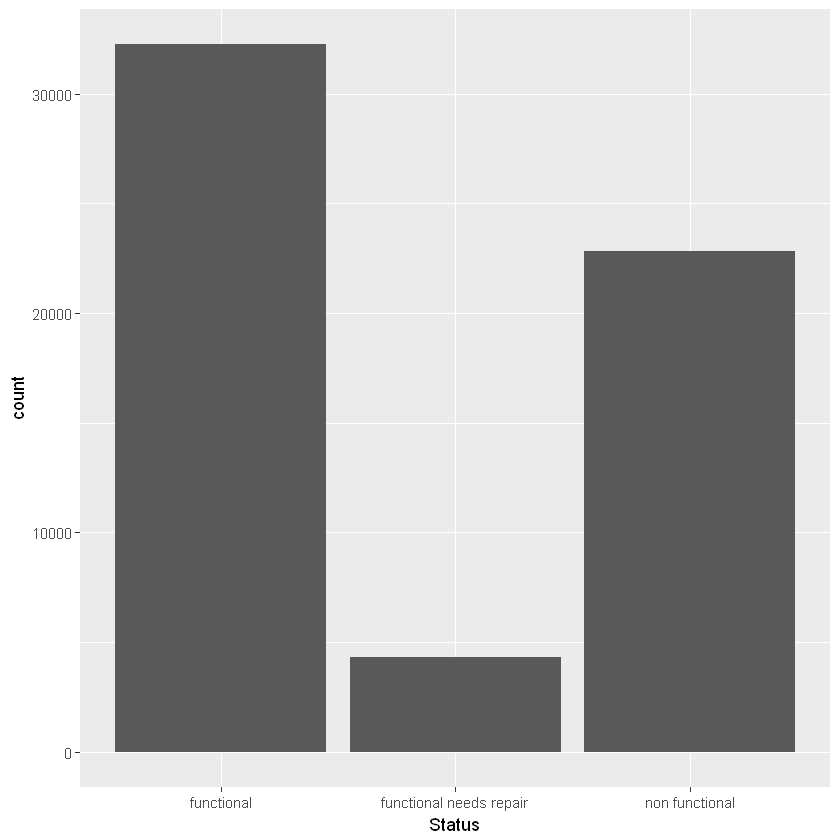

In [15]:
# Look at the distribution of labels (as a table) 
table(training$status_group)

# Look at the distribution of labels (as a table with percentage) 
prop.table(table(training$status_group))

# Look at the distribution of labels (as a bar plot)
library(ggplot2)
ggplot(training, aes(x = training$status_group)) + 
    geom_bar() +
    xlab("Status")

In [ ]:
# Look at the distribution of labels (as a table) 
table(training$status_group)

# Look at the distribution of labels (as a table with percentage) 
prop.table(table(training$status_group))

# Look at the distribution of labels (as a bar plot)
library(ggplot2)
ggplot(training, aes(x = training$status_group)) + 
    geom_bar() +
    xlab("Status")